In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit.quantum_info import SparsePauliOp, entanglement_of_formation, DensityMatrix

from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA
from scipy.optimize import minimize


import numpy as np
import matplotlib.pyplot as plt


from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import InstructionProperties

from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.primitives import Estimator
from qiskit_aer.primitives import EstimatorV2 as EstimatorAer
from qiskit_aer import AerSimulator


from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2,
    SamplerV2 as Sampler,
    EstimatorOptions
)


from qiskit.visualization import plot_distribution


from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.transformers import FreezeCoreTransformer, ActiveSpaceTransformer



from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint

from numba import njit, jit
import multiprocessing as mp


from entanglement_measures import GHZ_entanglmenetlike_measure, Multipartite_Negativity, multipartite_entanglement

In [ ]:

#@jit
def initialize_O3_vqe_chemical(intermolecular_distance= 1, binding_angle= np.pi/2 , basis = 'ccpvdz'):

    xcoord = intermolecular_distance * np.cos(binding_angle / 2)
    ycoord = intermolecular_distance * np.sin(binding_angle / 2)

    driver = PySCFDriver(atom=f"O 0 0 0; O {xcoord} {ycoord} 0; O {xcoord} {-1 * ycoord} 0", basis=basis)

    full_problem = driver.run()

    act_space_tf = ActiveSpaceTransformer(num_electrons= 2, num_spatial_orbitals= 4) #only two pair of ion electron pairs

    problem = act_space_tf.transform(full_problem)

    mapper = ParityMapper(num_particles=(problem.num_alpha, problem.num_beta))

    

    pauli_hamiltonian = mapper.map(problem.hamiltonian.second_q_op())


    #then we generate the Ansatz
    init_state = HartreeFock(problem.num_spatial_orbitals,
                         problem.num_particles,
                         mapper)

    ansatz = UCCSD(problem.num_spatial_orbitals,
               problem.num_particles,
               mapper,
               initial_state= init_state)
    
    return ansatz, pauli_hamiltonian, problem


#@jit
def vqe_chemical_ansatz(estimator, ansatz, problem, mapper=JordanWignerMapper(), optimizer= SLSQP()):
    vqe = VQE(estimator= estimator,
              ansatz= ansatz,
              optimizer= optimizer)

    mapper = ParityMapper(num_particles= (problem.num_alpha, problem.num_beta))

    initial_point = HFInitialPoint()
    initial_point.ansatz = ansatz
    initial_point.problem = problem

    vqe.initial_point = initial_point.to_numpy_array()
    solver = GroundStateEigensolver(mapper, vqe)

    result = solver.solve(problem)

    gs_energy = result.total_energies[0]
    utilized_ansatz = result.groundstate[0]
    optimized_parameters = result.groundstate[1]

    optimal_ansatz = utilized_ansatz.assign_parameters(optimized_parameters)

    return gs_energy, optimal_ansatz



#@jit
def run_calculation_for_O3_gs(swept_interval, angle_interval ,estimator):

    with mp.Pool() as pool:

        distances = swept_interval
        angles = angle_interval

        num_dist = len( swept_interval )
        num_angl = len( angle_interval)

        shape_of_mesh = (num_angl, num_dist)

        entanglement_list_max = np.zeros(shape= shape_of_mesh)
        entanglement_list_total = np.zeros(shape= shape_of_mesh)

        negativity_list_max = np.zeros(shape= shape_of_mesh)
        negativity_list_total = np.zeros(shape= shape_of_mesh)

        ghz_measure_list = np.zeros(shape= shape_of_mesh)

        energiesH2_list = np.zeros(shape= shape_of_mesh)


        for i, d in enumerate(swept_interval):
            for j, a in enumerate(angle_interval):

                ansatz_h2, pauli_ham_h2, prob = initialize_O3_vqe_chemical(intermolecular_distance= d,
                                                                        binding_angle= a)

                gs_energy_d, optimal_ansatz_d = vqe_chemical_ansatz(estimator=estimator,
                                                                    ansatz= ansatz_h2,
                                                                    problem= prob)
            

                r = DensityMatrix(optimal_ansatz_d)

        

                energiesH2_list[i][j] = gs_energy_d

                entanglement_list_max[i][j]  = multipartite_entanglement(optimal_ansatz_d, rho= r, mode= 'max' )
                entanglement_list_total[i][j] = multipartite_entanglement(optimal_ansatz_d, rho= r, mode= 'total')
            
                
                negativity_list_max[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'max')
                negativity_list_total[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'total')
                
                ghz_measure_list[i][j]  = GHZ_entanglmenetlike_measure(optimal_ansatz_d)

        return energiesH2_list, entanglement_list_max, entanglement_list_total, negativity_list_max, negativity_list_total, ghz_measure_list

In [3]:
distances = np.linspace(0.9, 1.4 , 35)
angles_interval = np.linspace(np.pi/4, 8 * np.pi/9, num= 35)

estimator = Estimator()


energies_O3, entgmax_O3, entgtotal_O3, negmax_O3, negtotal_O3, ghzmeasure_O3 = run_calculation_for_O3_gs(swept_interval= distances, angle_interval= angles_interval ,estimator= estimator)

/home/hd/workspace/Thesis-VQE/TriAtomic Molecule/entanglement_measures.py:55: ComplexWarning: Casting complex values to real discards the imaginary part
  negativity_matrix[ind_i][ind_j] = Bipartite_Negativity(rho_p)


In [15]:
import pickle

data_O3_pt1 = [energies_O3, entgmax_O3, entgtotal_O3, negmax_O3, negtotal_O3, ghzmeasure_O3]

with open('ozone_data.pkl', 'wb') as f:
    pickle.dump(data_O3_pt1, f)


In [1]:
import pickle

with open('ozone_data.pkl', 'rb') as f:
    load_list = pickle.load(f)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 2.9 MB/s eta 0:00:0000:0100:01


In [4]:
!pip install kaleido


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 2.6 MB/s eta 0:00:0000:0100:01m


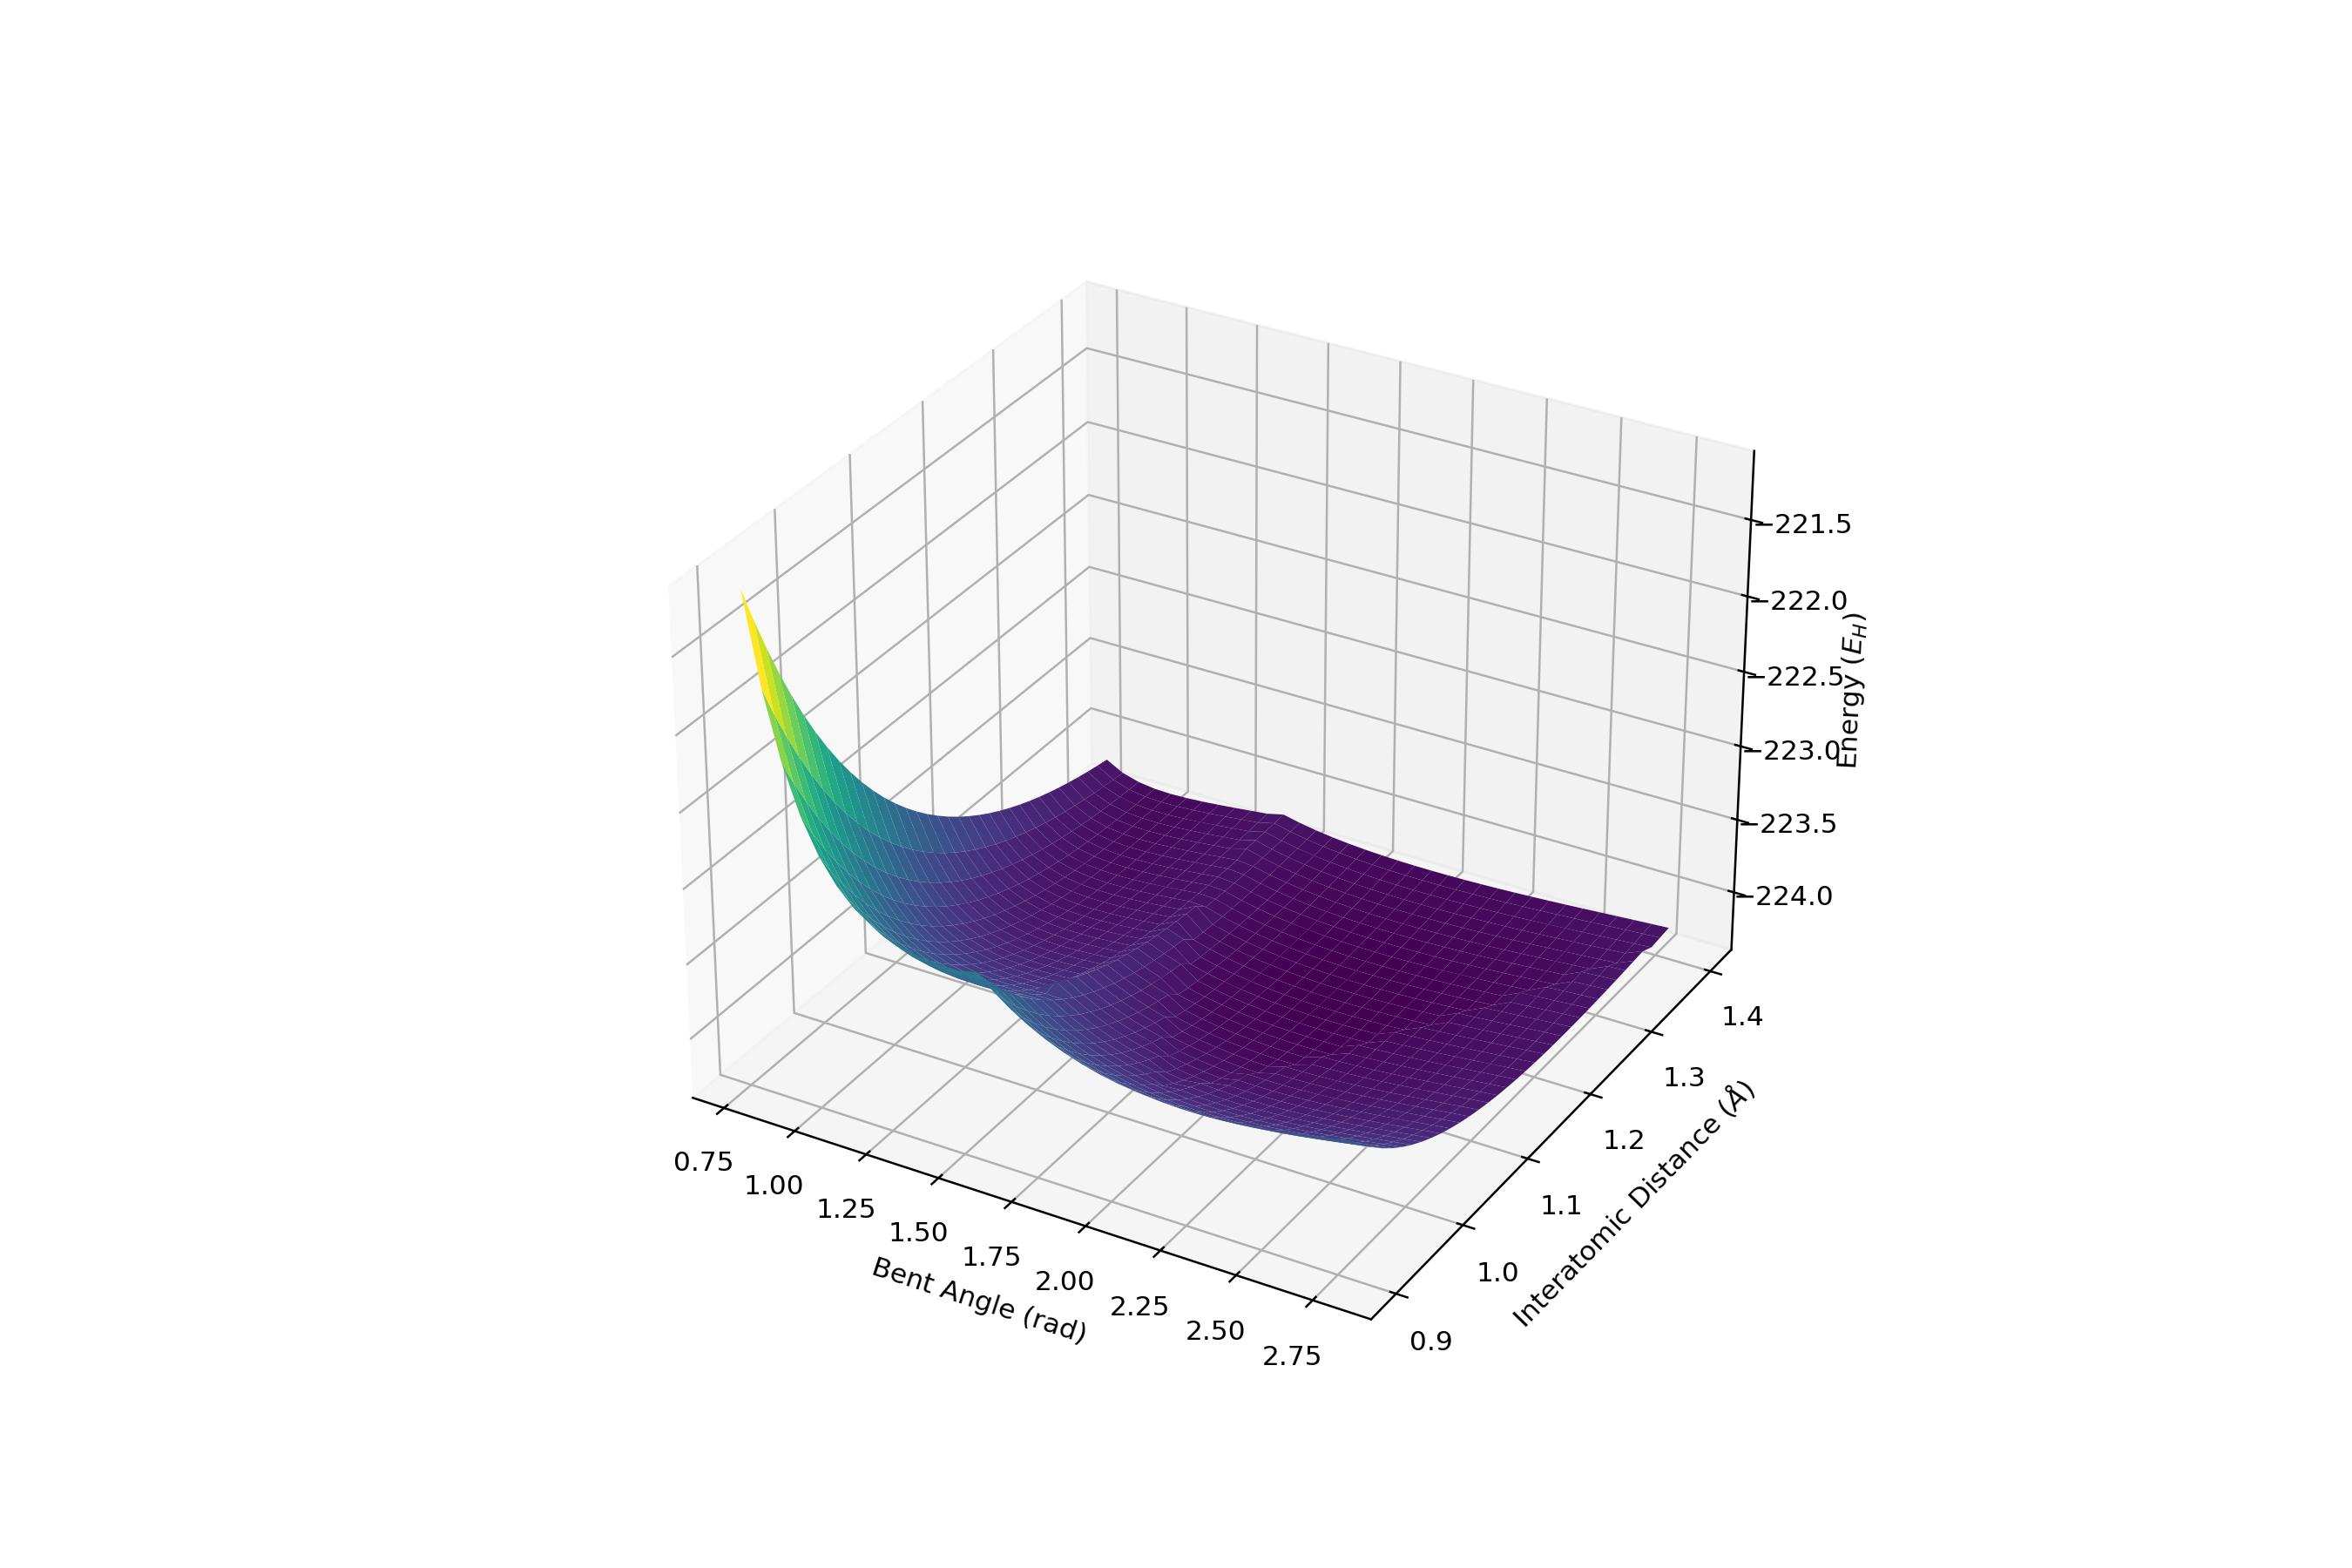

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Suponiendo que ya tienes tus datos en load_list
distances = np.linspace(0.9, 1.4, 35)
angles_interval = np.linspace(np.pi / 4, 8 * np.pi / 9, num=35)

%matplotlib widget


# Convertir la lista de listas en un array de NumPy
Z = np.array(load_list[0])

# Crear una malla para las coordenadas x y y
x = angles_interval  # Número de columnas
y = distances        # Número de filas
X, Y = np.meshgrid(x, y)

# Crear la figura 3D
fig = plt.figure(figsize=(12, 8), dpi=225)

#fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

# Añadir etiquetas
ax.set_xlabel('Bent Angle (rad)')
ax.set_ylabel(r'Interatomic Distance ($\AA$)')
ax.set_zlabel(r'Energy ($E_H$)')

# Guardar como imagen SVG
#plt.savefig('figuras/mi_grafico.svg', format='svg')

# Mostrar la figura
plt.show()


In [12]:
plt.savefig('ozone2.svg', format='svg')


In [4]:
import numpy as np
import plotly.graph_objects as go

# Datos de ejemplo (sustituye esto con tus propios datos)
distances = np.linspace(0.9, 1.4, 35)
angles_interval = np.linspace(np.pi / 4, 8 * np.pi / 9, num=35)

# Simulación de Z (sustituye esto con tus datos reales)
Z = np.array(load_list[0])
# Crear una malla para las coordenadas x y y
X, Y = np.meshgrid(angles_interval, distances)

# Crear la figura 3D
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')])

# Añadir etiquetas
fig.update_layout(
    title='3D Surface Plot',
    scene=dict(
        xaxis_title='Bent Angle',
        yaxis_title='Intermolecular Distance',
        zaxis_title='Energy'
    )
)

# Mostrar el gráfico
fig.show()


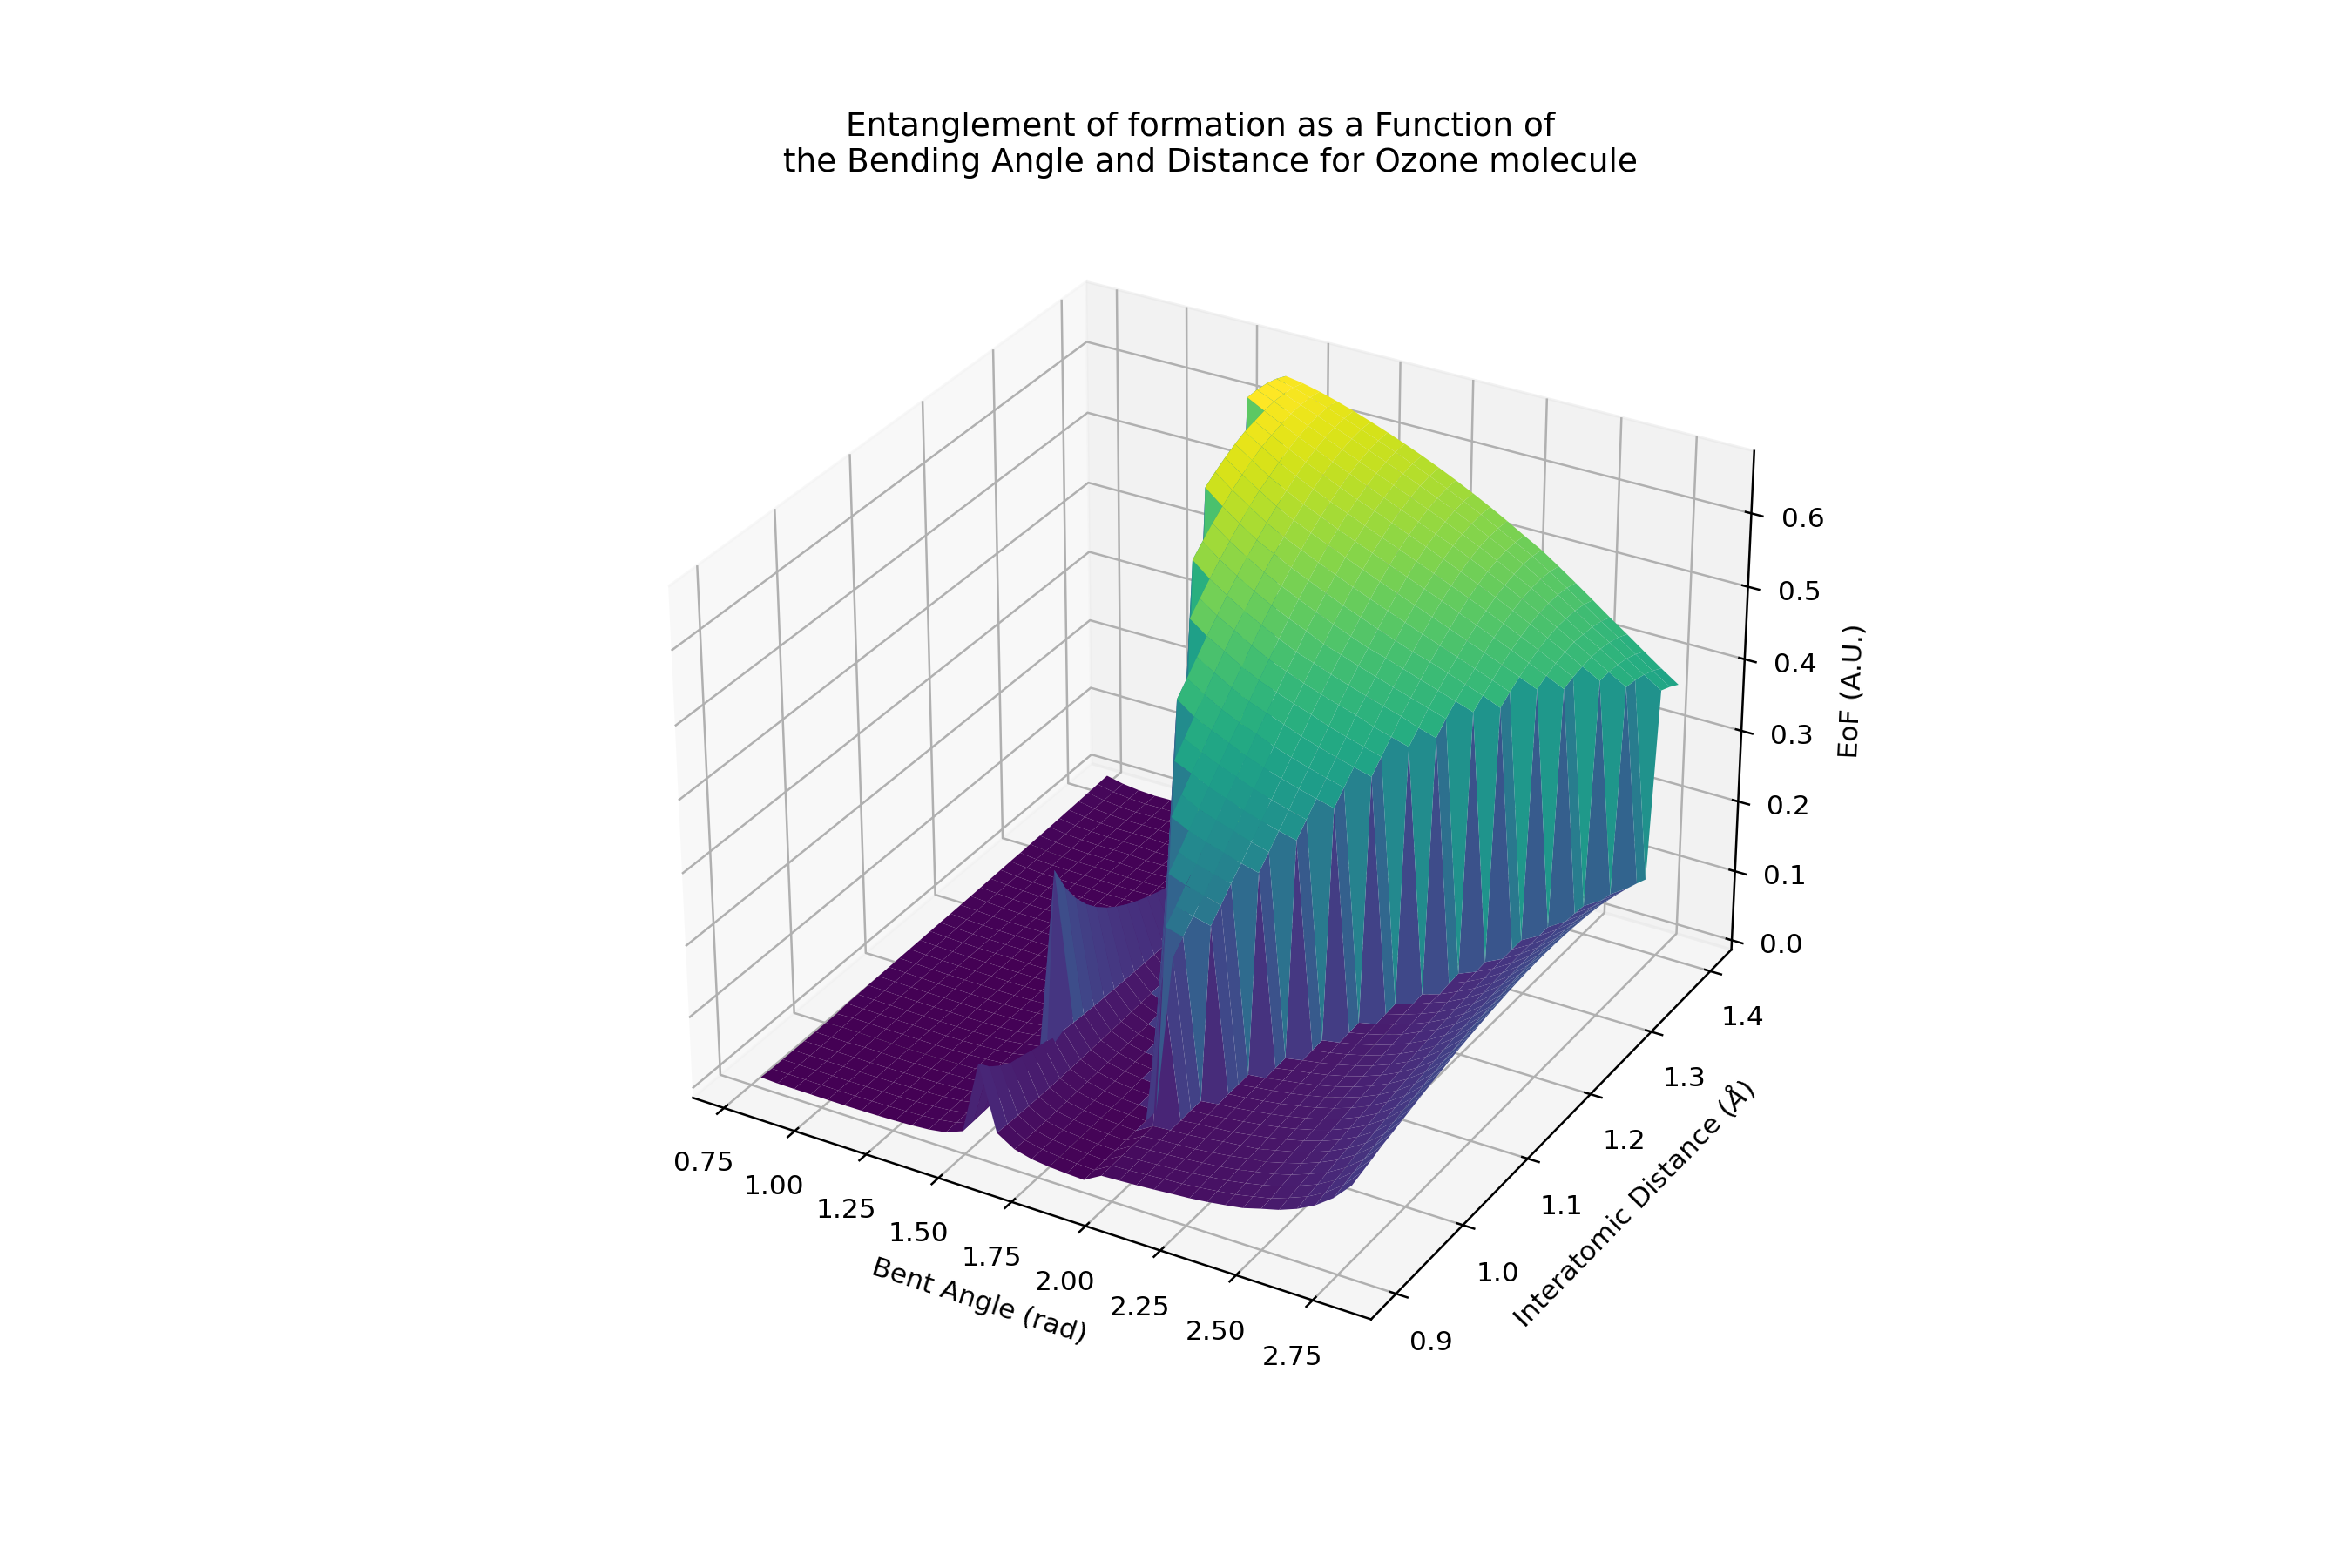

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Suponiendo que ya tienes tus datos en load_list
distances = np.linspace(0.9, 1.4, 35)
angles_interval = np.linspace(np.pi / 4, 8 * np.pi / 9, num=35)

%matplotlib widget


# Convertir la lista de listas en un array de NumPy
Z = np.array(load_list[2])

# Crear una malla para las coordenadas x y y
x = angles_interval  # Número de columnas
y = distances        # Número de filas
X, Y = np.meshgrid(x, y)

# Crear la figura 3D
fig = plt.figure(figsize=(12, 8), dpi=225)

#fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

# Añadir etiquetas
ax.set_xlabel('Bent Angle (rad)')
ax.set_ylabel(r'Interatomic Distance ($\AA$)')
ax.set_zlabel(r'EoF (A.U.)')
ax.set_title('Entanglement of formation as a Function of \n the Bending Angle and Distance for Ozone molecule')


# Guardar como imagen SVG
#plt.savefig('figuras/mi_grafico.svg', format='svg')

# Mostrar la figura
plt.show()


In [18]:
plt.savefig('ozone2_EoF.svg', format='svg')


[[0.00175466 0.0006028  0.00044708 ... 0.07229634 0.09022394 0.11547562]
 [0.00085307 0.00061943 0.0004604  ... 0.07603516 0.09449039 0.12015853]
 [0.00088289 0.00064132 0.00047743 ... 0.07961872 0.09853181 0.12451306]
 ...
 [0.01317371 0.00886712 0.00644861 ... 0.42254349 0.40690652 0.39184604]
 [0.01391418 0.00927202 0.00668142 ... 0.41719976 0.40089481 0.38527225]
 [0.01469613 0.00969605 0.00685655 ... 0.40957338 0.3927088  0.3766453 ]]


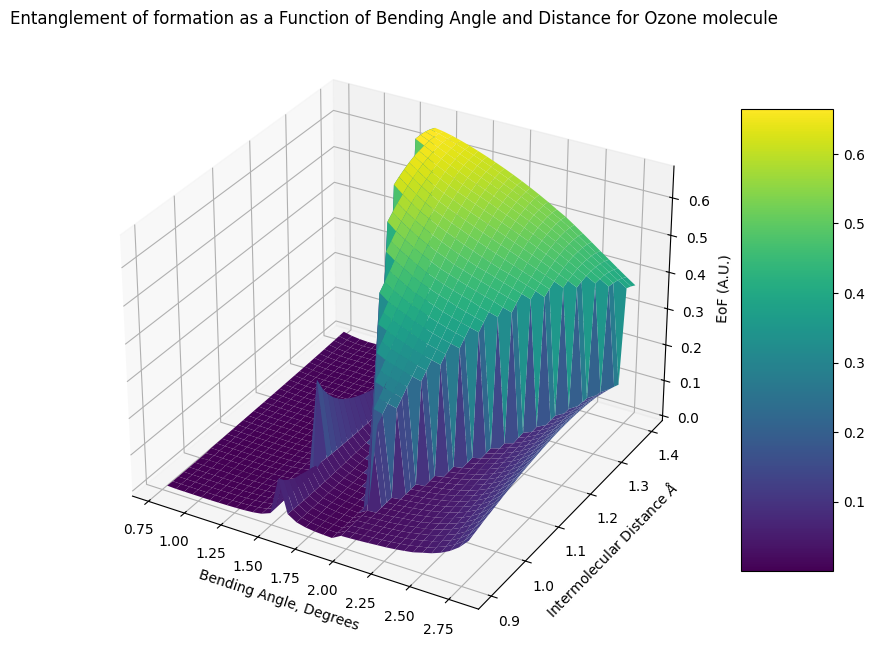

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Enable interactive mode


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

distances = np.linspace(0.9, 1.4 , 35)
angles_interval = np.linspace(np.pi/4, 8 * np.pi/9, num= 35)

angles_grid, distances_grid = np.meshgrid(angles_interval, distances)

# Example energy function (replace with your actual data or function)
# This is a placeholder, replace with your actual calculation or data retrieval method
energies = entgtotal_O3

print(energies)

# Plot surface
surf = ax.plot_surface(angles_grid, distances_grid, energies, cmap='viridis')

# Customize plot
ax.set_xlabel(r'Bending Angle, Degrees')
ax.set_ylabel(r'Intermolecular Distance $\AA$')
ax.set_zlabel('EoF (A.U.)')
ax.set_title('Entanglement of formation as a Function of Bending Angle and Distance for Ozone molecule')

# Add color bar
fig.colorbar(surf, ax=ax, shrink=0.75, aspect=5)

plt.show()

In [3]:
distances = np.linspace(0.6, 1.6, 45)
angles_interval = np.linspace(5*np.pi /9, 0.72 * np.pi ,  num= 45) #from 100 to 130 degrees

estimator = Estimator()


energies_O3_pt2, entgmax_O3_pt2, entgtotal_O3_pt2, negmax_O3_pt2, negtotal_O3_pt2, ghzmeasure_O3_pt2 = run_calculation_for_O3_gs(swept_interval= distances, angle_interval= angles_interval ,estimator= estimator)

/home/herbert/workspace/Thesis-VQE/TriAtomic Molecule/entanglement_measures.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  negativity_matrix[ind_i][ind_j] = Bipartite_Negativity(rho_p)


In [29]:
print(np.min(energies_O3_pt2))

-224.33209636103598


In [4]:
dataaa = [energies_O3_pt2, entgmax_O3_pt2, entgtotal_O3_pt2, negmax_O3_pt2, negtotal_O3_pt2, ghzmeasure_O3_pt2]

In [14]:
%store dataaa

Stored 'dataaa' (list)


/home/herbert/workspace/vqe_venv/lib/python3.11/site-packages/IPython/extensions/storemagic.py:229: UserWarning: This is now an optional IPython functionality, setting autorestore/dataaa requires you to install the `pickleshare` library.
  db[ 'autorestore/' + arg ] = obj


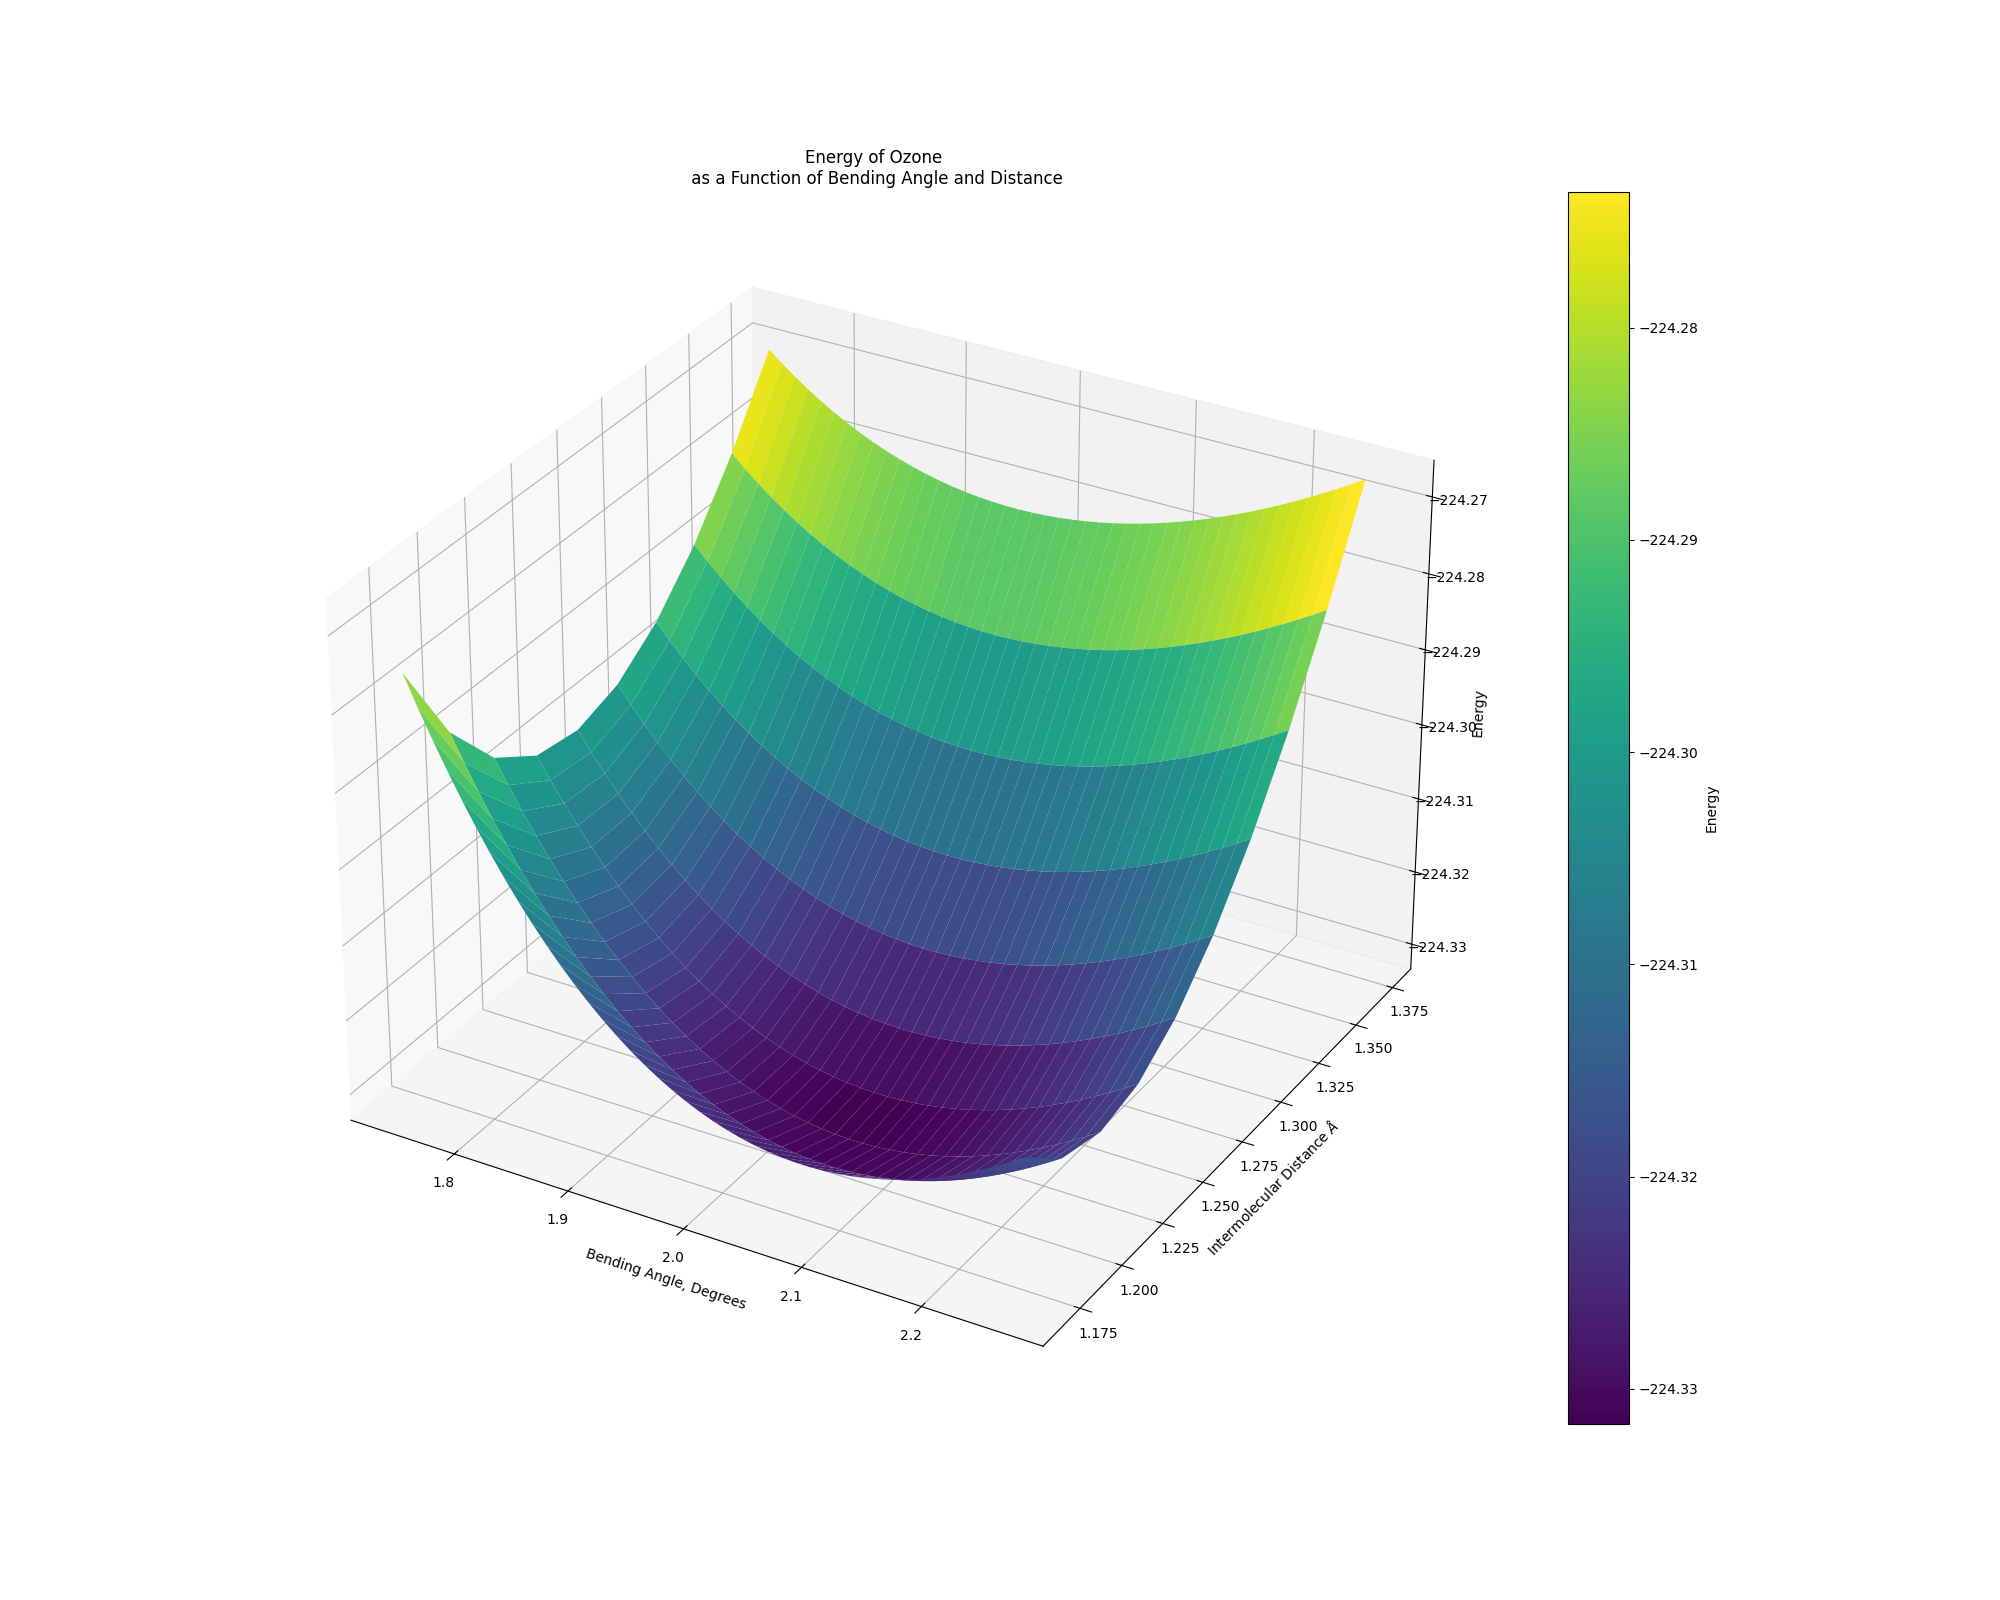

In [37]:
%matplotlib widget

distances = np.linspace(0.6, 1.6, 45)
angles_interval = np.linspace(5*np.pi /9, 0.72 * np.pi ,  num= 45) #from 100 to 130 degrees

# Add color bar
#%matplotlib widget

fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111, projection='3d')


angles_grid, distances_grid = np.meshgrid(angles_interval, distances[25:35])

# Example energy function (replace with your actual data or function)
# This is a placeholder, replace with your actual calculation or data retrieval method
#energies = (energies_O3_pt2 - np.min(energies_O3_pt2)) / (np.max(energies_O3_pt2) - np.min(energies_O3_pt2))
energies = energies_O3_pt2[:][25:35]

# Plot surface
#surf = ax.plot_surface(angles_grid, distances_grid, energies, cmap='viridis')

contour = ax.plot_surface(angles_grid, distances_grid, energies, cmap= 'viridis')

# Customize plot
ax.set_xlabel(r'Bending Angle, Degrees')
ax.set_ylabel(r'Intermolecular Distance $\AA$')
ax.set_zlabel('Energy')
ax.set_title('Energy of Ozone\n as a Function of Bending Angle and Distance')

# Add color bar
fig.colorbar(contour, label= 'Energy')
plt.show()

In [34]:
emin = np.min(energies_O3_pt2)
print(emin)

-224.33209636103598


In [33]:
np.argwhere(energies_O3_pt2 == emin)

print(f'd = {np.linspace(0.6, 1.6, 45)[27]} a = {np.linspace(5*np.pi /9, 0.72 * np.pi ,  num= 45)[26] }')

d = 1.2136363636363636 a = 2.050603204797701


[27 26]


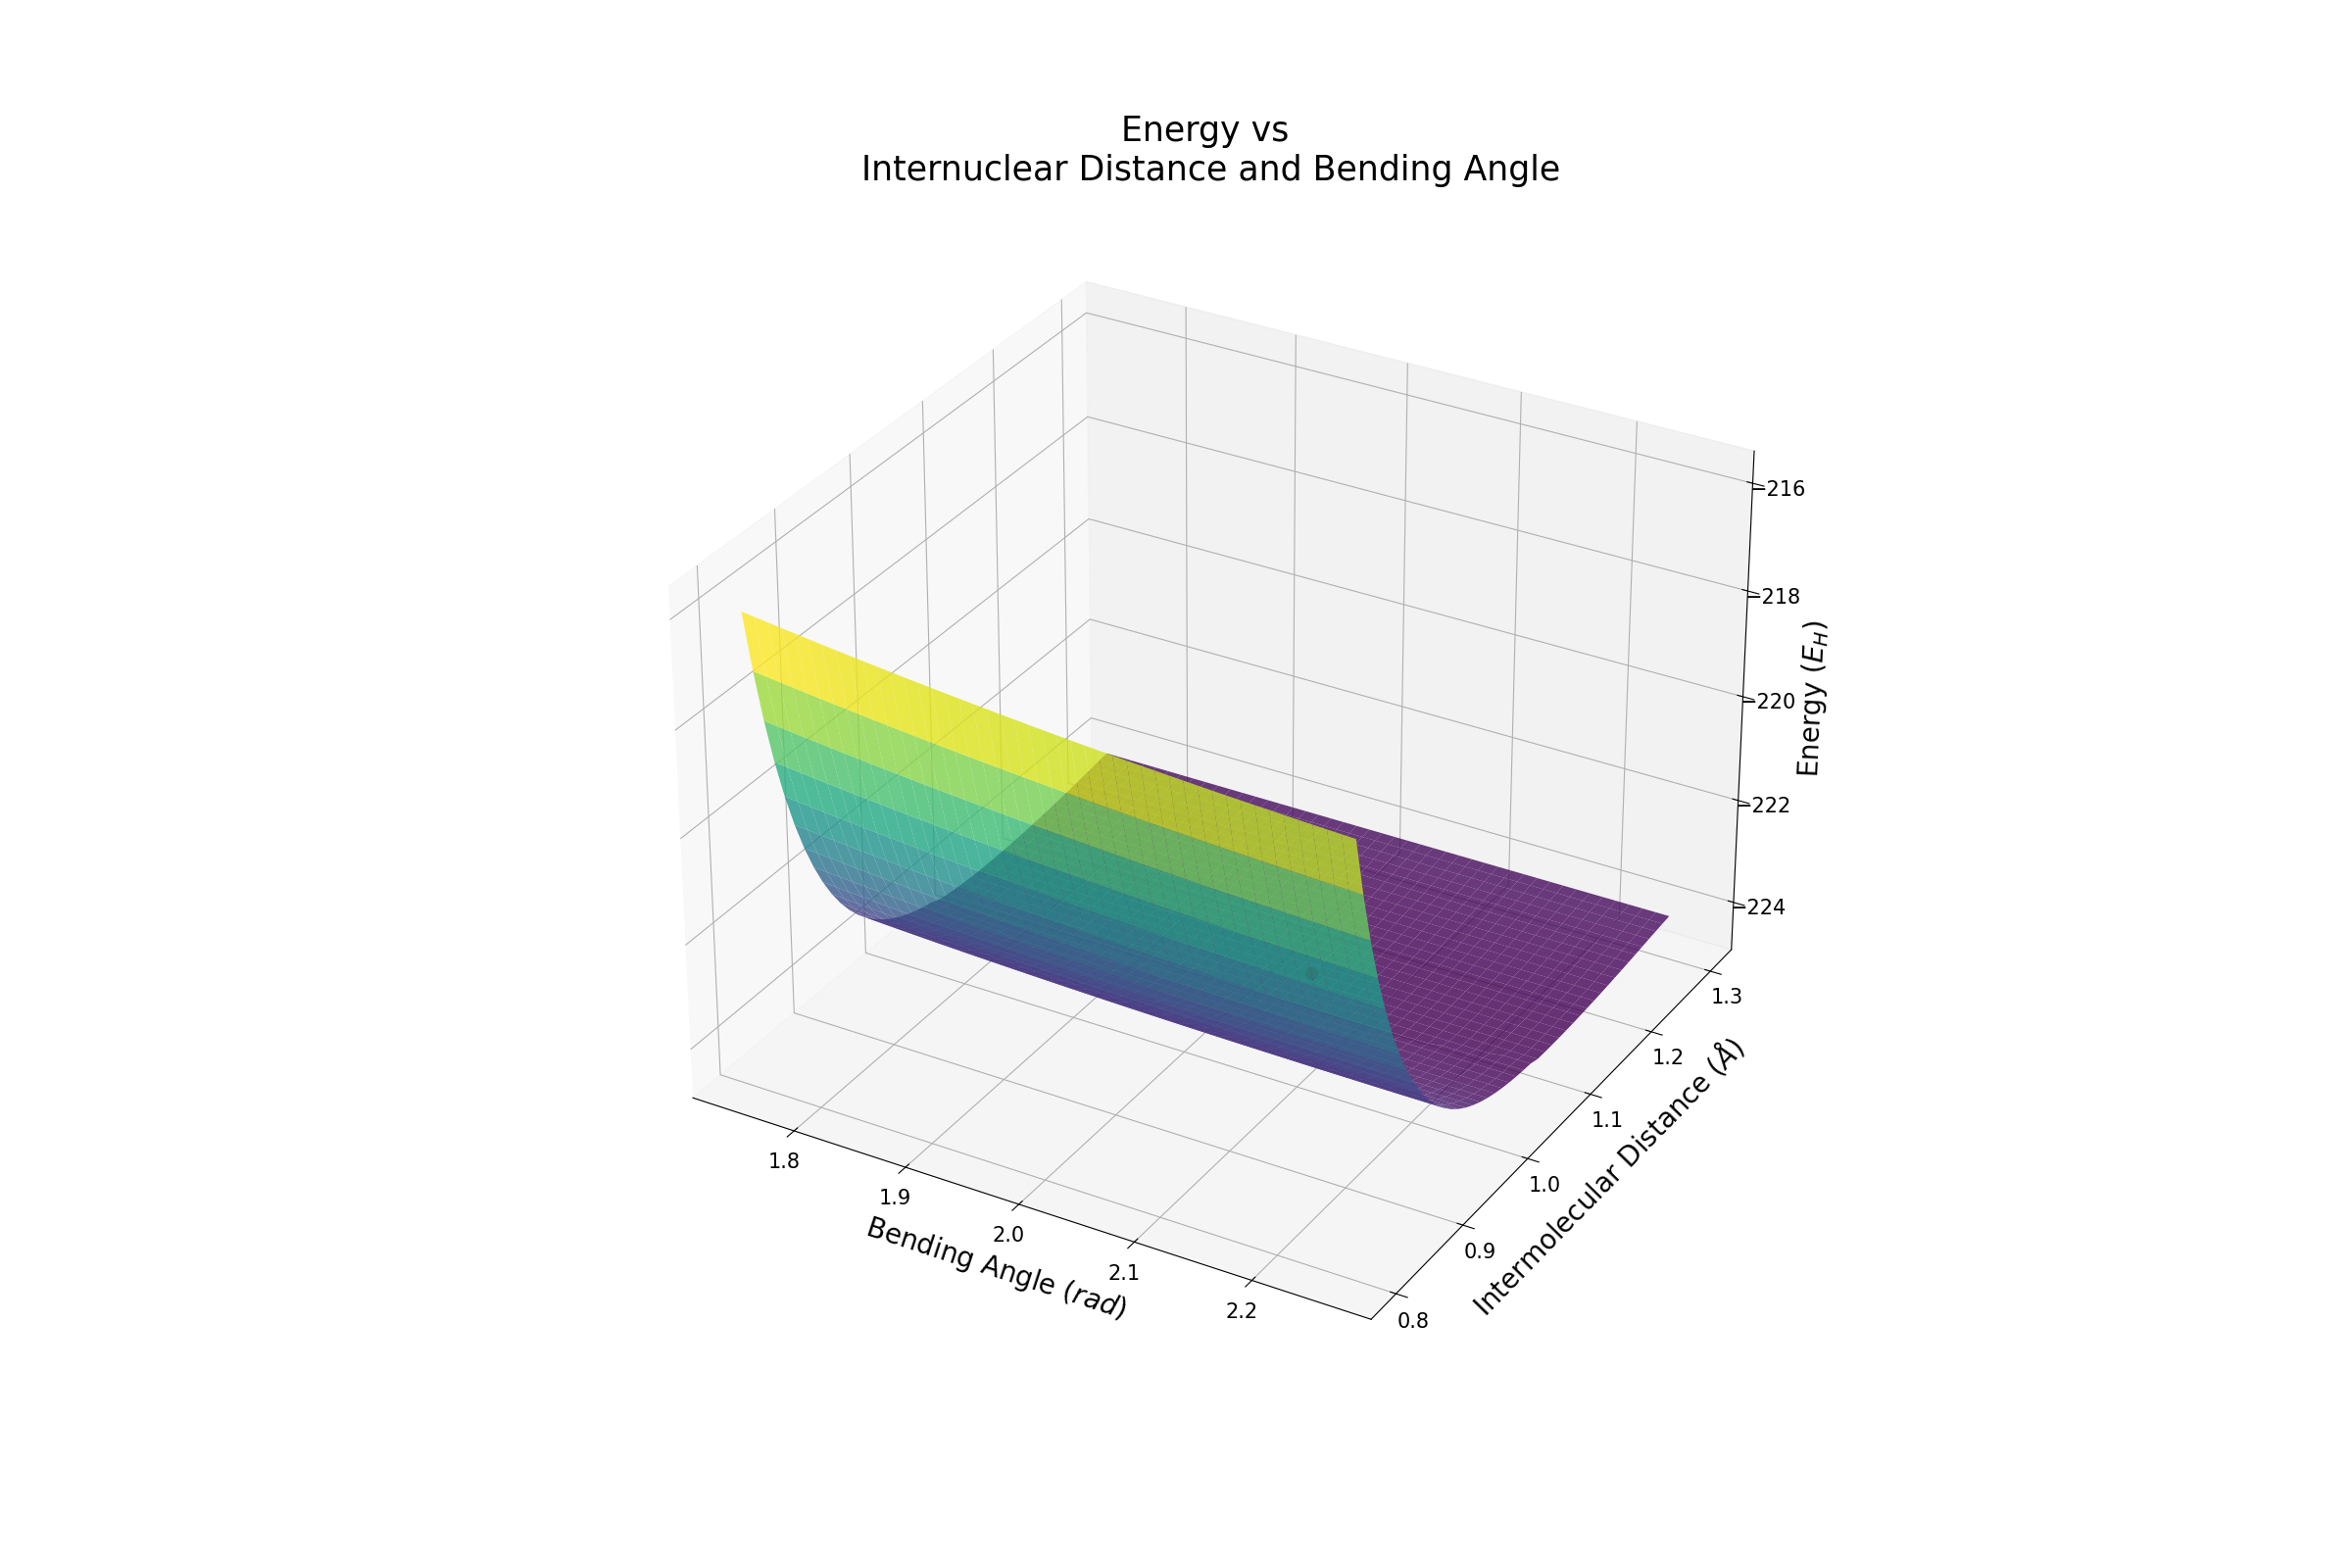

In [47]:
%matplotlib widget

distances = np.linspace(0.8, 1.3, 45)
angles_interval = np.linspace(5*np.pi /9, 0.72 * np.pi ,  num= 45) #from 100 to 130 degrees

# Add color bar
#%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FuncFormatter

# Enable interactive mode
%matplotlib widget




fig = plt.figure(figsize=(24, 16))
ax = fig.add_subplot(111, projection='3d')



angles_grid, distances_grid = np.meshgrid(angles_interval, distances)

# Example energy function (replace with your actual data or function)
# This is a placeholder, replace with your actual calculation or data retrieval method
energies = energies_O3_pt2

# Plot surface
surf = ax.plot_surface(angles_grid, distances_grid, energies, cmap='viridis', alpha= 0.8)

# Customize plot
ax.set_xlabel('\nBending Angle ($rad$)',fontsize= 20)
ax.set_ylabel('\nIntermolecular Distance ($\AA$)', fontsize= 20)
ax.set_zlabel('\nEnergy ($E_H$)', fontsize= 20)
ax.set_title('Energy vs\n Internuclear Distance and Bending Angle', fontsize= 25)

point_z = np.min(energies_O3_pt2)

xy = np.argwhere(energies == point_z)[0]

point_y = distances[xy[0]]
point_x = angles_interval[xy[1]]

print(xy)

ax.scatter(point_x, point_y, point_z, color='red', s=75)



plt.tick_params(axis='both', which='major', labelsize=15)  # Change the label size here

# Add color bar
#fig.colorbar(surf, ax=ax)

plt.show()

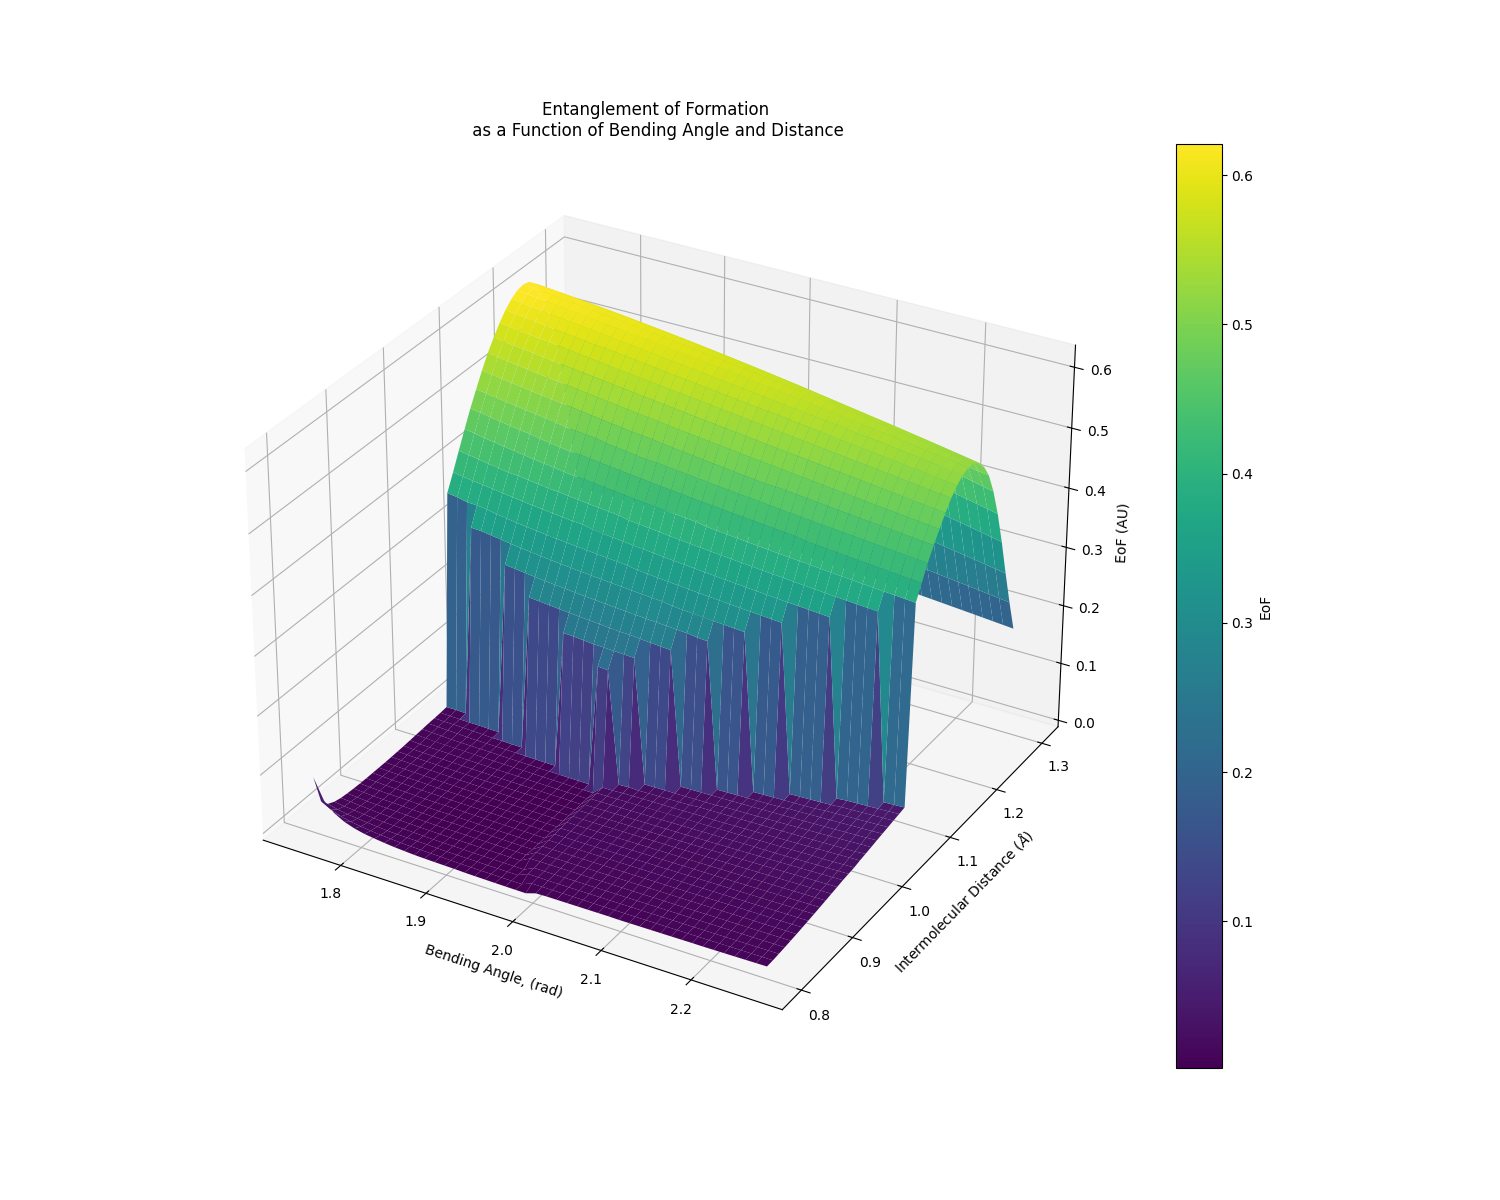

In [39]:
distances = np.linspace(0.8, 1.3, 45)
angles_interval = np.linspace(5*np.pi /9, 0.72 * np.pi ,  num= 45) #from 100 to 130 degrees

# Add color bar
#%matplotlib widget

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')



angles_grid, distances_grid = np.meshgrid(angles_interval, distances)

# Example energy function (replace with your actual data or function)
# This is a placeholder, replace with your actual calculation or data retrieval method
energies = entgmax_O3_pt2

# Plot surface
#surf = ax.plot_surface(angles_grid, distances_grid, energies, cmap='viridis')

contour = ax.plot_surface(angles_grid, distances_grid, energies, cmap= 'viridis')

# Customize plot
ax.set_xlabel(r'Bending Angle, (rad)')
ax.set_ylabel(r'Intermolecular Distance ($\AA$)')
ax.set_zlabel('EoF (AU)')
ax.set_title('Entanglement of Formation\n as a Function of Bending Angle and Distance')

# Add color bar
fig.colorbar(contour, label= 'EoF')
plt.show()

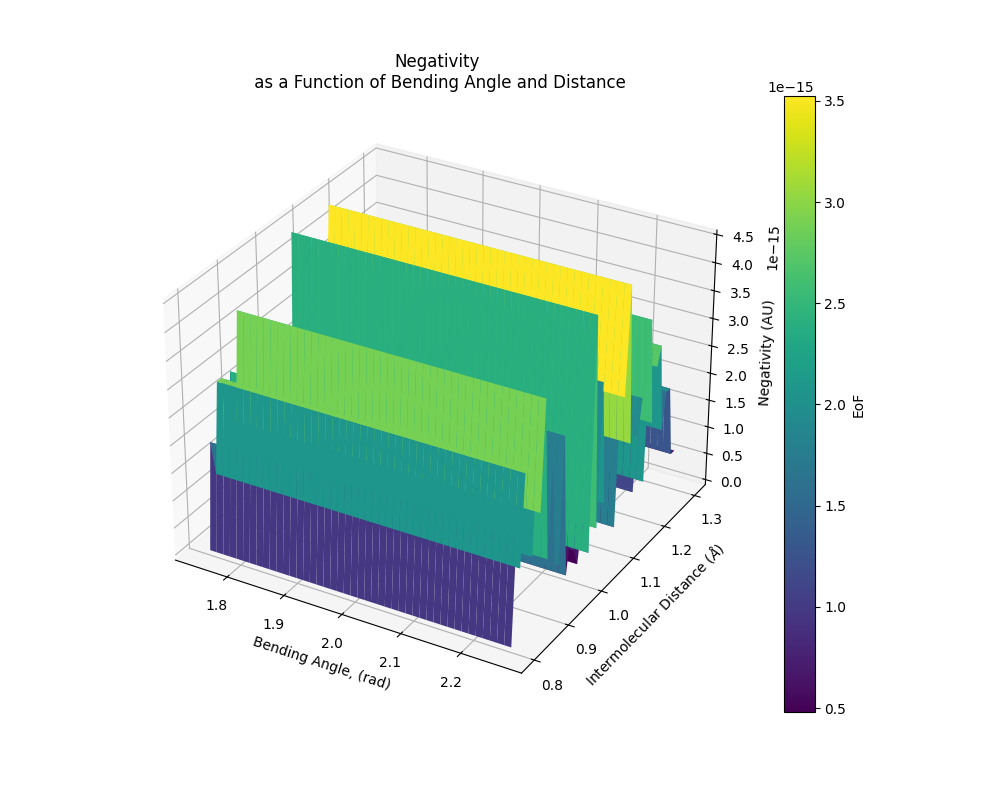

In [45]:
distances = np.linspace(0.8, 1.3, 45)
angles_interval = np.linspace(5*np.pi /9, 0.72 * np.pi ,  num= 45) #from 100 to 130 degrees

# Add color bar
#%matplotlib widget

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')



angles_grid, distances_grid = np.meshgrid(angles_interval, distances)

# Example energy function (replace with your actual data or function)
# This is a placeholder, replace with your actual calculation or data retrieval method
energies = np.log2((2 * negtotal_O3_pt2 + 1))

# Plot surface
#surf = ax.plot_surface(angles_grid, distances_grid, energies, cmap='viridis')

contour = ax.plot_surface(angles_grid, distances_grid, energies, cmap= 'viridis')

# Customize plot
ax.set_xlabel(r'Bending Angle, (rad)')
ax.set_ylabel(r'Intermolecular Distance ($\AA$)')
ax.set_zlabel('Negativity (AU)')
ax.set_title('Negativity\n as a Function of Bending Angle and Distance')

# Add color bar
fig.colorbar(contour, label= 'EoF')
plt.show()

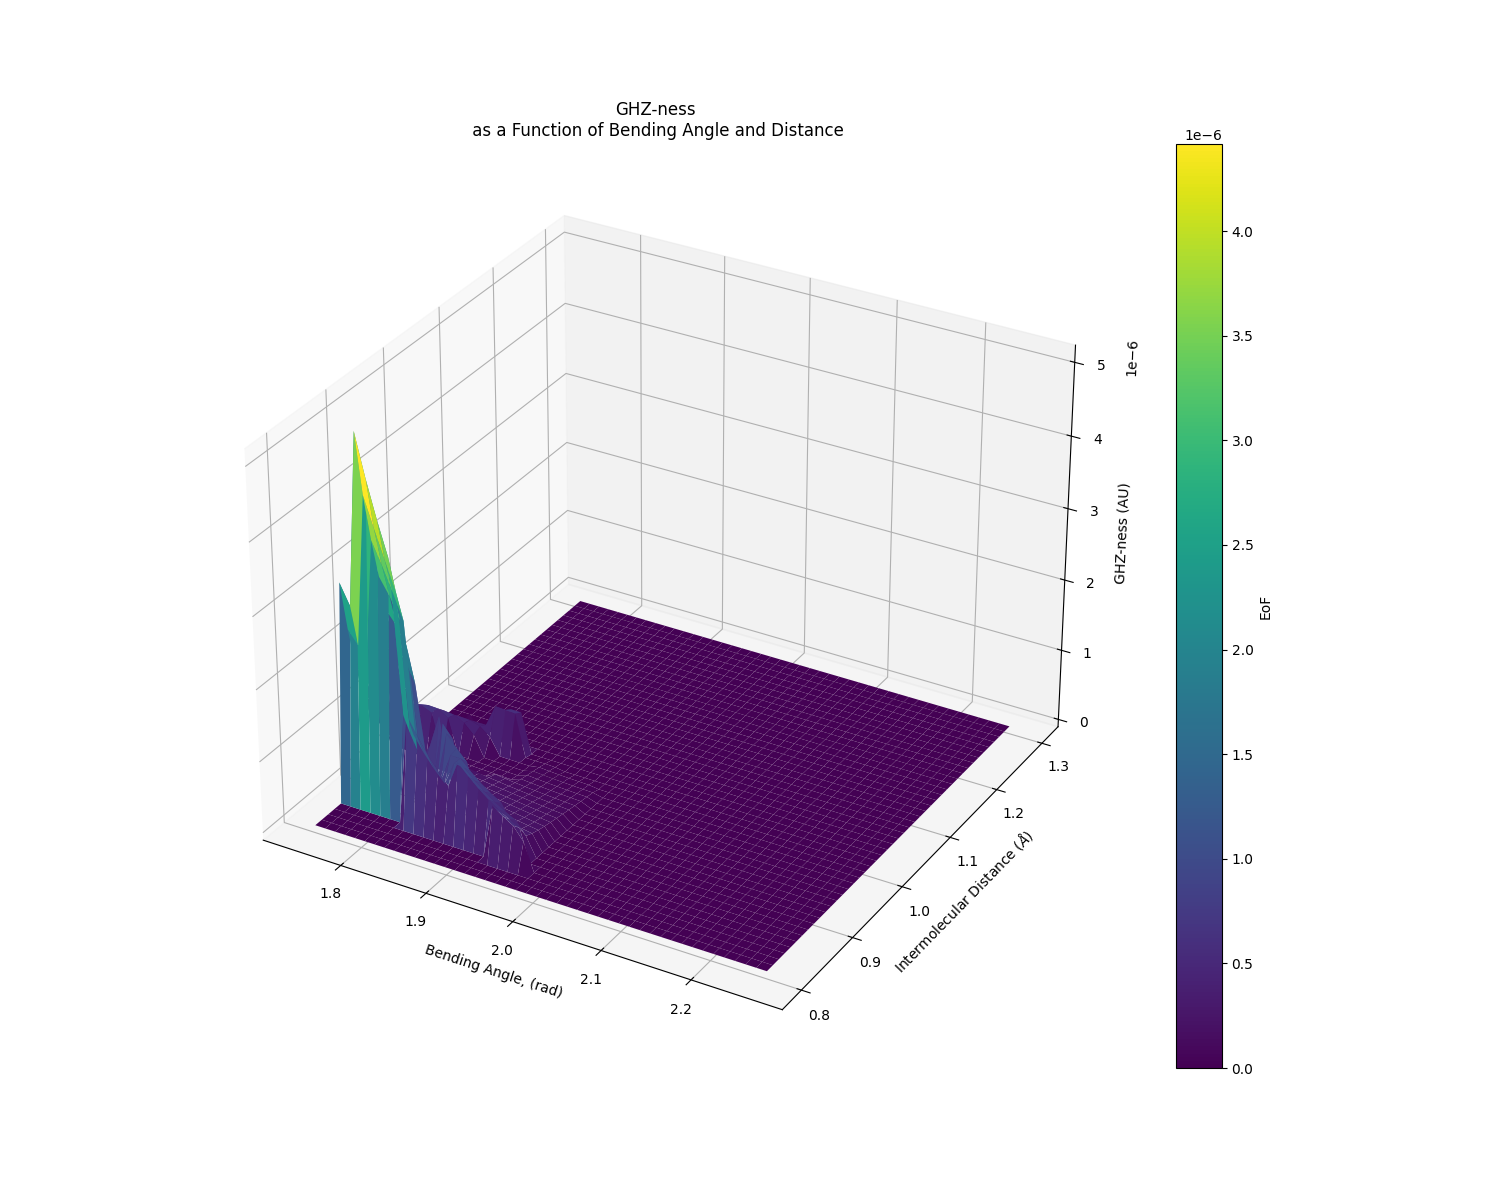

In [46]:
distances = np.linspace(0.8, 1.3, 45)
angles_interval = np.linspace(5*np.pi /9, 0.72 * np.pi ,  num= 45) #from 100 to 130 degrees

# Add color bar
#%matplotlib widget

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')



angles_grid, distances_grid = np.meshgrid(angles_interval, distances)

# Example energy function (replace with your actual data or function)
# This is a placeholder, replace with your actual calculation or data retrieval method
energies = ghzmeasure_O3_pt2

# Plot surface
#surf = ax.plot_surface(angles_grid, distances_grid, energies, cmap='viridis')

contour = ax.plot_surface(angles_grid, distances_grid, energies, cmap= 'viridis')

# Customize plot
ax.set_xlabel(r'Bending Angle, (rad)')
ax.set_ylabel(r'Intermolecular Distance ($\AA$)')
ax.set_zlabel('GHZ-ness (AU)')
ax.set_title('GHZ-ness\n as a Function of Bending Angle and Distance')

# Add color bar
fig.colorbar(contour, label= 'EoF')
plt.show()

In [25]:
distances = np.linspace(0.6, 1.6, 20)
angles_interval = np.linspace(np.pi/3 , np.pi ,  num= 20) #from 100 to 130 degrees

estimator = Estimator()


energies_O3_pt3, entgmax_O3_pt3, entgtotal_O3_pt3, negmax_O3_pt3, negtotal_O3_pt3, ghzmeasure_O3_pt3 = run_calculation_for_O3_gs(swept_interval= distances, angle_interval= angles_interval ,estimator= estimator)

/home/herbert/workspace/Thesis-VQE/TriAtomic Molecule/entanglement_measures.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  negativity_matrix[ind_i][ind_j] = Bipartite_Negativity(rho_p)


/tmp/ipykernel_2594/3269264474.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(15, 12))


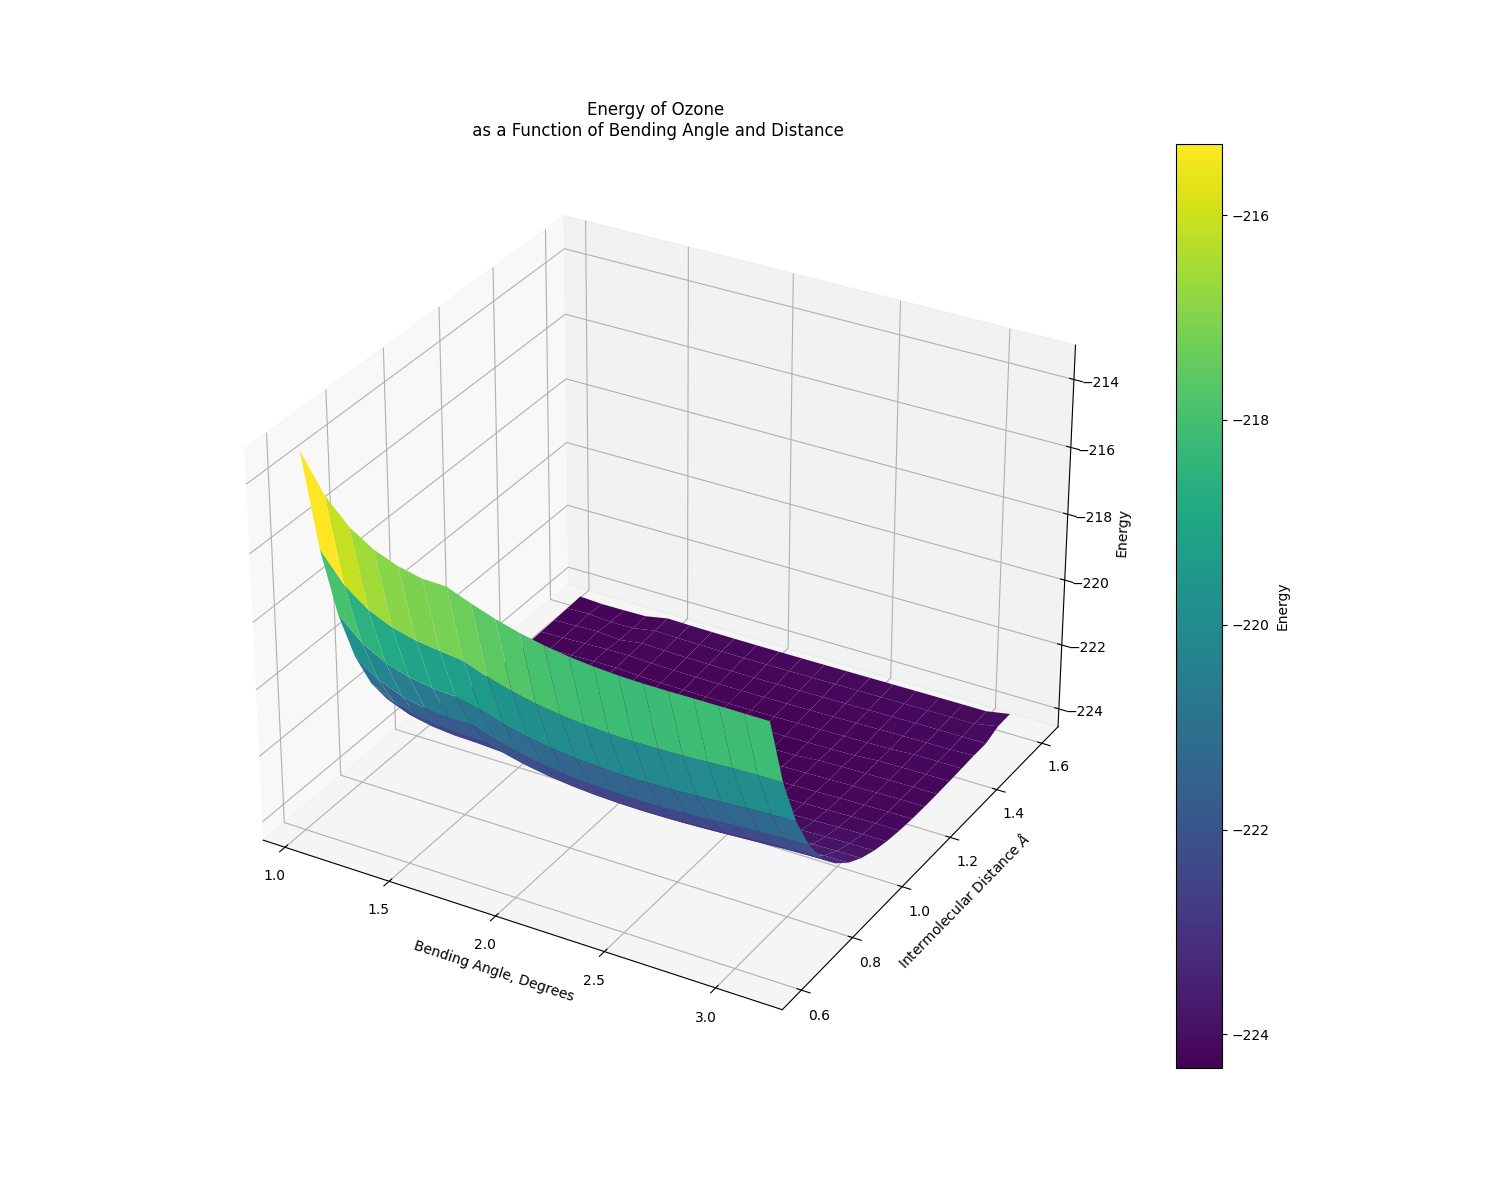

In [27]:
%matplotlib widget

distances = np.linspace(0.6, 1.6, 20)
angles_interval = np.linspace(np.pi/3 , np.pi ,  num= 20) #from 100 to 130 degrees

# Add color bar
#%matplotlib widget

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')



angles_grid, distances_grid = np.meshgrid(angles_interval, distances)

# Example energy function (replace with your actual data or function)
# This is a placeholder, replace with your actual calculation or data retrieval method
energies = energies_O3_pt3

# Plot surface
#surf = ax.plot_surface(angles_grid, distances_grid, energies, cmap='viridis')

contour = ax.plot_surface(angles_grid, distances_grid, energies, cmap= 'viridis')

# Customize plot
ax.set_xlabel(r'Bending Angle, Degrees')
ax.set_ylabel(r'Intermolecular Distance $\AA$')
ax.set_zlabel('Energy')
ax.set_title('Energy of Ozone\n as a Function of Bending Angle and Distance')

# Add color bar
fig.colorbar(contour, label= 'Energy')
plt.show()